Data fields
 
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 
0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d
    
Assortment - describes an assortment level: a = basic, b = extra, c = extended. Read more about assortment here
    
CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from xgboost import XGBClassifier
import category_encoders as ce
from sklearn import model_selection
from sklearn.metrics import accuracy_score



In [2]:

%matplotlib inline

In [3]:
train_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\train.csv')

C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
train_data.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [5]:
test_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\test.csv')

In [6]:
test_data.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


In [7]:
store_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\store.csv')

In [8]:
store_data.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


# 1. Data Preprocessing

In [9]:
train_data.info()
#it doesn't contain null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [10]:
#open column has one missing value
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [11]:
#Columns: CompetitionDistance, CompetitionOpenSinceMonth ,CompetitionOpenSinceYear, Promo2SinceWeek,Promo2SinceYear, PromoInterval 
#has missing values
store_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [12]:
store_data.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

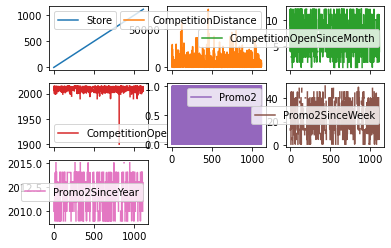

In [13]:
store_data.plot(subplots=True, layout=(3,3))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

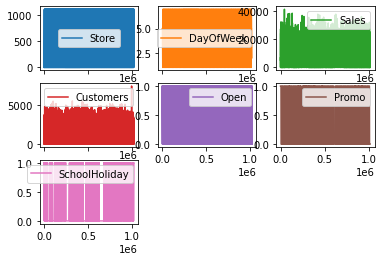

In [14]:
train_data.plot(subplots=True, layout=(3,3))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

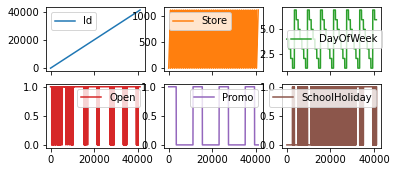

In [15]:
test_data.plot(subplots=True, layout=(3,3))

In [16]:
 #Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [17]:
missing_values_table(train_data)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,Dtype


In [18]:
missing_values_table(test_data)

Your selected dataframe has 8 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Open,11,0.0,float64


In [19]:
missing_values_table(store_data)

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Promo2SinceWeek,544,48.8,float64
Promo2SinceYear,544,48.8,float64
PromoInterval,544,48.8,object
CompetitionOpenSinceMonth,354,31.7,float64
CompetitionOpenSinceYear,354,31.7,float64
CompetitionDistance,3,0.3,float64


In [20]:
def plot_count(df:pd.DataFrame, column:str) -> None:
    plt.figure(figsize=(12, 7))
    sb.countplot(data=df, x=column)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

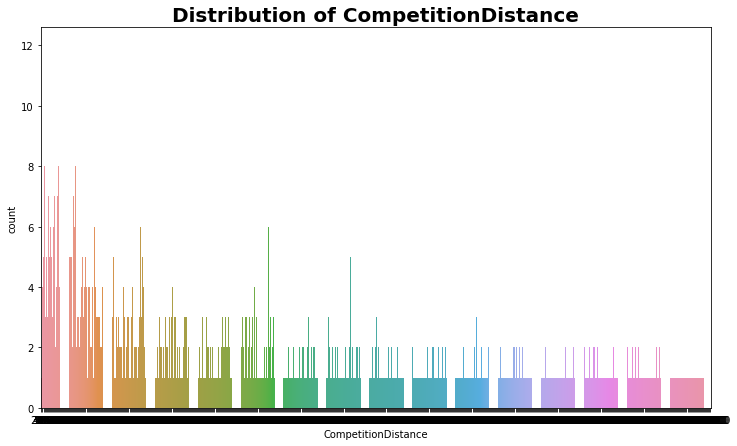

In [21]:
#before we fill missing value , lets first see distribution of each data
plot_count(store_data, "CompetitionDistance")

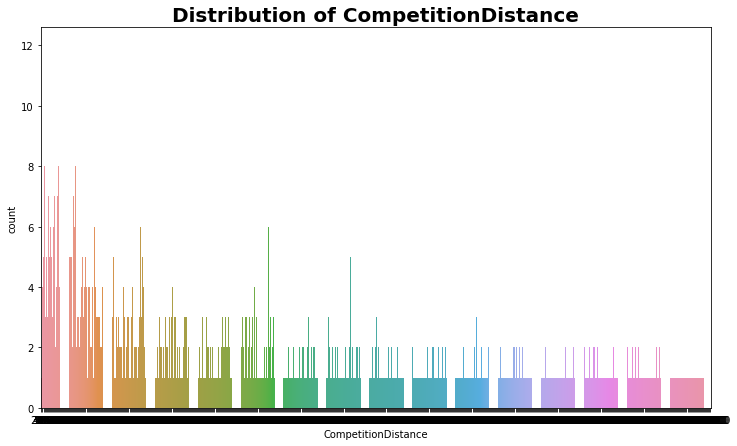

In [22]:
plot_count(store_data, "CompetitionDistance")

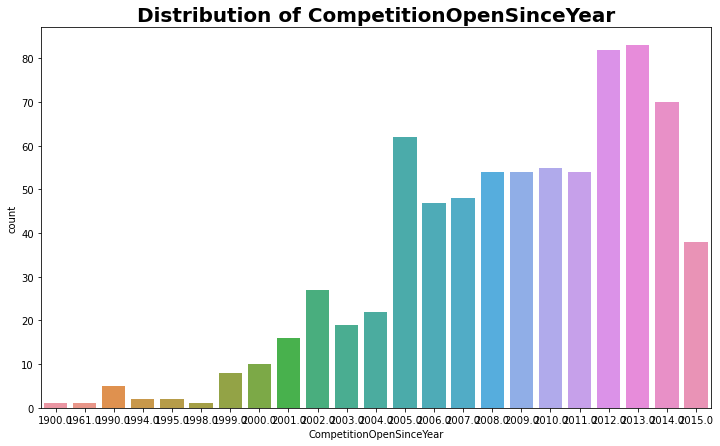

In [23]:
plot_count(store_data, "CompetitionOpenSinceYear")

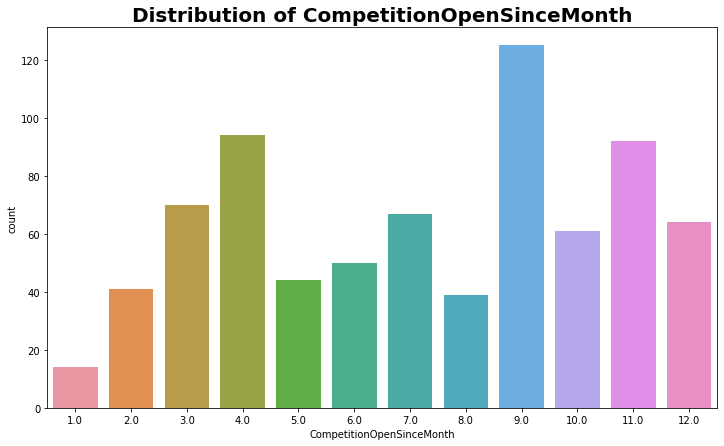

In [24]:
plot_count(store_data, "CompetitionOpenSinceMonth")

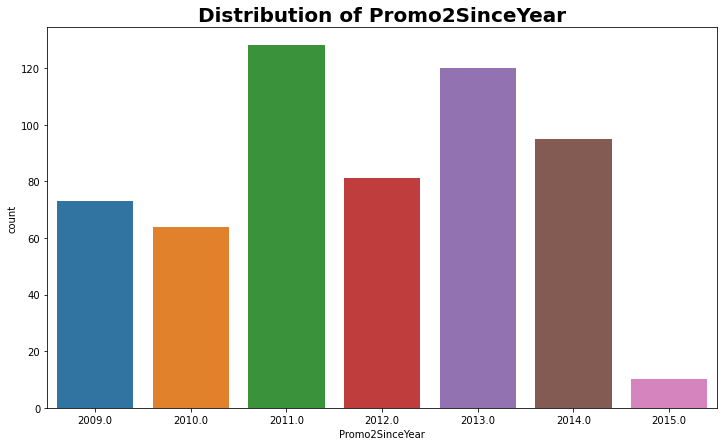

In [25]:
plot_count(store_data, "Promo2SinceYear")

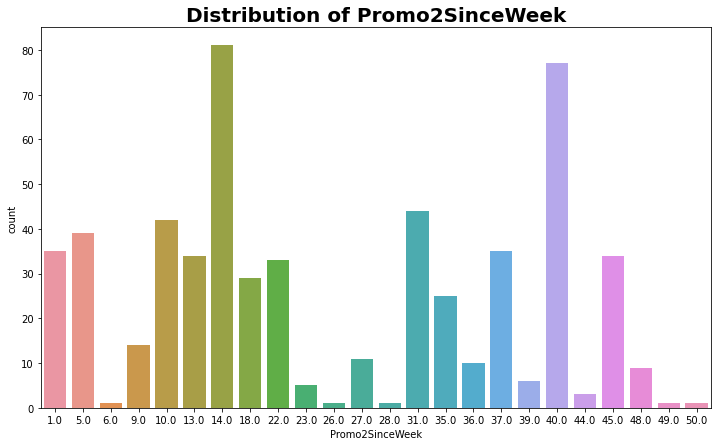

In [26]:
plot_count(store_data, "Promo2SinceWeek")

In [27]:
def fix_outlier(df, column):
    df[column] = np.where(df[column] > df[column].quantile(0.95), df[column].median(),df[column])
    
    return df[column]

def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    # plt.figure(figsize=(15, 10))
    # fig, ax = plt.subplots(1, figsize=(12, 7))
    sb.displot(data=df, x=column, color=color, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

In [28]:
def plot_box(df:pd.DataFrame, x_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sb.boxplot(data = df, x=x_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.show()

def plot_box_multi(df:pd.DataFrame, x_col:str, y_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sb.boxplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str, hue: str, style: str) -> None:
    plt.figure(figsize=(12, 7))
    sb.scatterplot(data = df, x=x_col, y=y_col, hue=hue, style=style)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

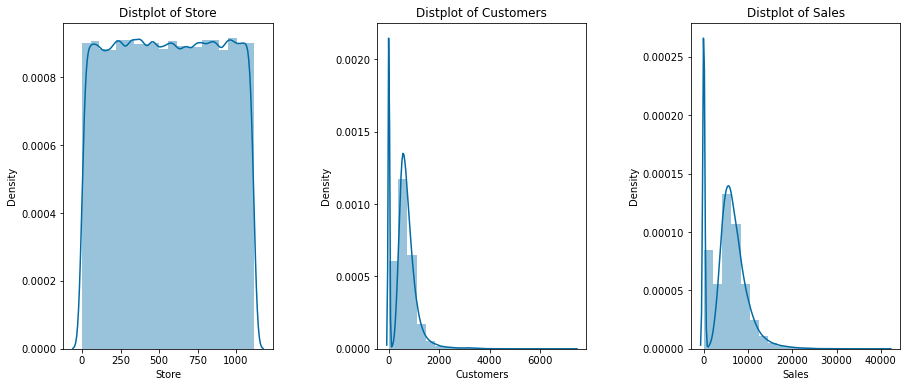

In [29]:
plt.style.use('tableau-colorblind10')
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Store','Customers', 'Sales']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =20 , wspace = 0.5)
    sb.distplot(train_data[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

Skewness measure

Fairly Symmetrical	-0.5 to 0.5

Moderate Skewed	-0.5 to -1.0 and 0.5 to 1.0

Highly Skewed	< -1.0 and > 1.0

In [30]:
#measure skewness 
print(train_data.agg(['skew']).transpose())
#SchoolHoliday,Open,Customers are highly skewed and Sales moderatly skewed and other are fairly skewed

                   skew
Store         -0.000955
DayOfWeek      0.001593
Sales          0.641460
Customers      1.598650
Open          -1.758045
Promo          0.487838
SchoolHoliday  1.677842


In [31]:
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(), inplace =True)

In [32]:
store_data.CompetitionOpenSinceMonth.fillna(0, inplace = True)
store_data.CompetitionOpenSinceYear.fillna(0,inplace=True)

In [33]:
store_data.Promo2SinceWeek.fillna(0,inplace=True)
store_data.Promo2SinceYear.fillna(0,inplace=True)
store_data.PromoInterval.fillna(0,inplace=True)
test_data.Open.fillna(0,inplace=True)

In [34]:
#persent of non missing value
store_data.count(0)/store_data.shape[0] * 100

Store                        100.0
StoreType                    100.0
Assortment                   100.0
CompetitionDistance          100.0
CompetitionOpenSinceMonth    100.0
CompetitionOpenSinceYear     100.0
Promo2                       100.0
Promo2SinceWeek              100.0
Promo2SinceYear              100.0
PromoInterval                100.0
dtype: float64

In [35]:
missing_values_table(store_data)

Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,Dtype


In [36]:
#measure skewness 
print(test_data.agg(['skew']).transpose())

                   skew
Id             0.000000
Store          0.010899
DayOfWeek      0.028468
Open          -2.006200
Promo          0.426030
SchoolHoliday  0.227518


In [37]:
#measure skewness 
print(store_data.agg(['skew']).transpose())

                               skew
Store                      0.000000
CompetitionDistance        2.934389
CompetitionOpenSinceMonth  0.187676
CompetitionOpenSinceYear  -0.785114
Promo2                    -0.048510
Promo2SinceWeek            0.950294
Promo2SinceYear           -0.048506


Normalizing skew data

In [38]:
# define a method to scale data, looping thru the columns, and passing a scaler
def scale_data(data, scaler):
    columns=data.columns
    for col in columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

In [39]:
def plotvar(df, variable):
    plt.subplot(1,2,2)
    sb.boxplot(df[variable])
    plt.show()

C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


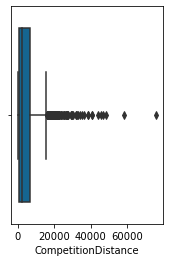

In [40]:
plotvar(store_data,'CompetitionDistance')

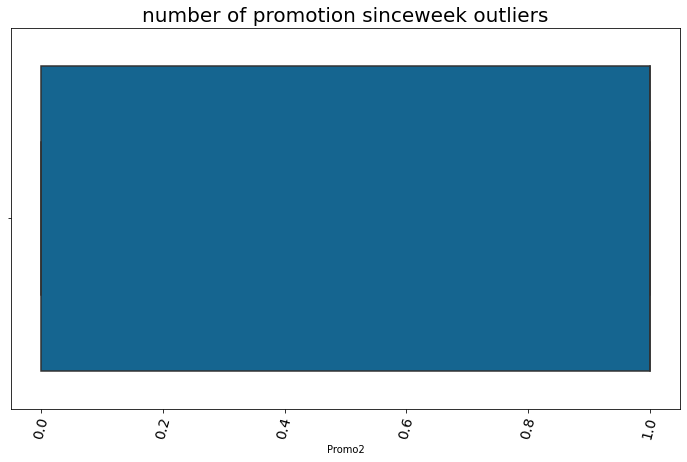

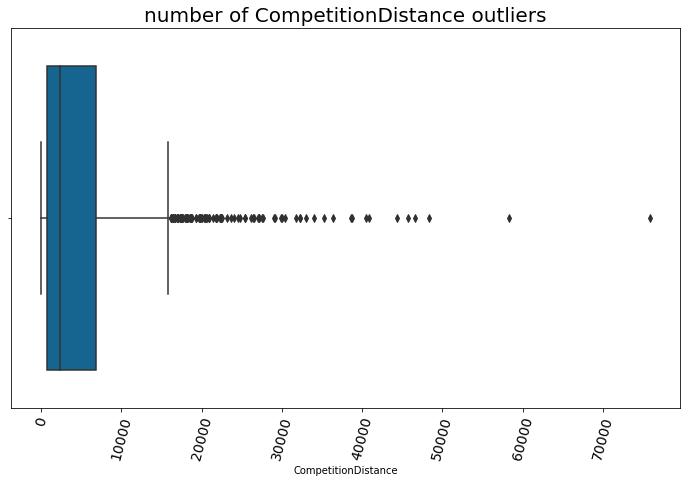

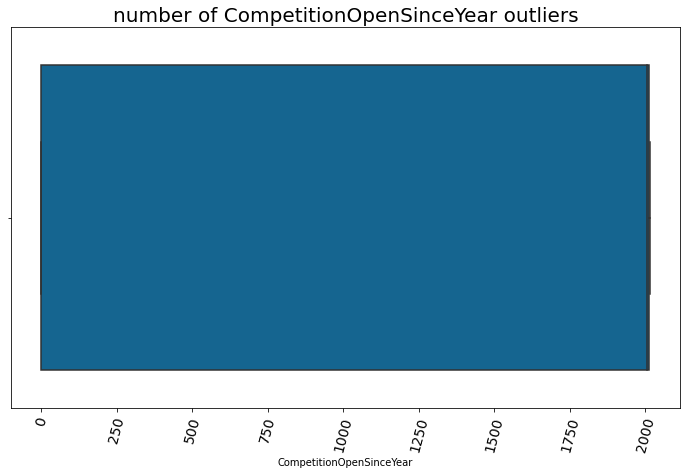

In [41]:
plot_box(store_data, "Promo2", "number of promotion sinceweek outliers")
plot_box(store_data, "CompetitionDistance", "number of CompetitionDistance outliers")
plot_box(store_data, "CompetitionOpenSinceYear", "number of CompetitionOpenSinceYear outliers")

In [42]:
#fix outliers
fix_outlier(store_data, 'CompetitionDistance')



0        1270.0
1         570.0
2       14130.0
3         620.0
4        2325.0
         ...   
1110     1900.0
1111     1880.0
1112     9260.0
1113      870.0
1114     5350.0
Name: CompetitionDistance, Length: 1115, dtype: float64

C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


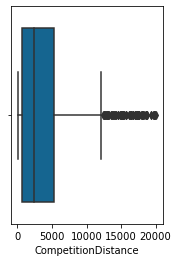

In [43]:
plotvar(store_data,'CompetitionDistance')

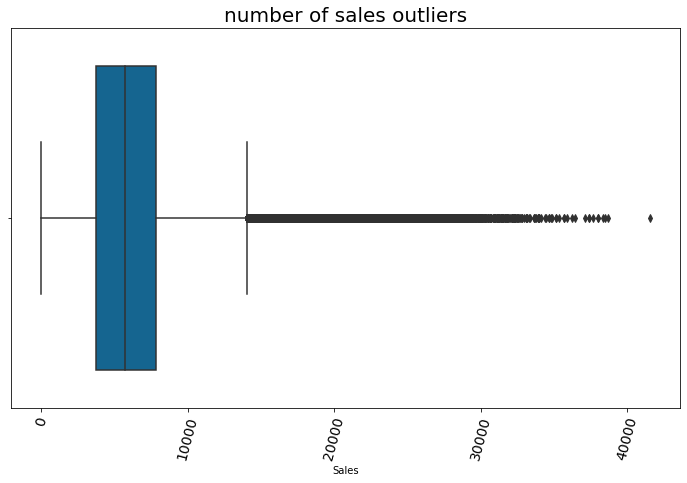

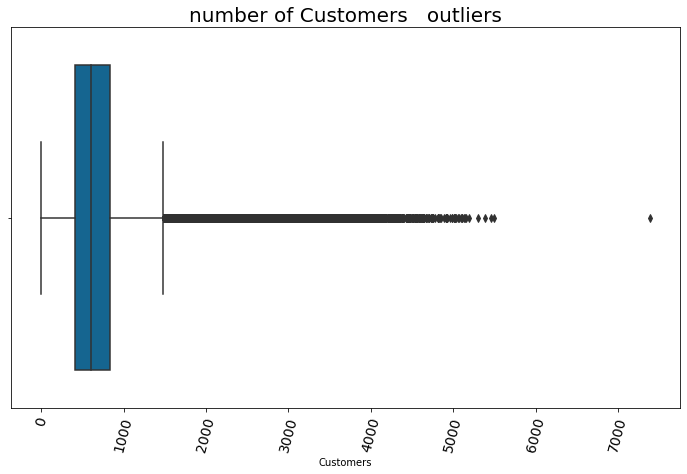

In [44]:
plot_box(train_data, "Sales", "number of sales outliers")
plot_box(train_data, "Customers", "number of Customers   outliers")


In [45]:
#fix outliers
fix_outlier(train_data, 'Sales')
#fix outliers
fix_outlier(train_data, 'Customers')

0          555.0
1          625.0
2          821.0
3          609.0
4          559.0
           ...  
1017204      0.0
1017205      0.0
1017206      0.0
1017207      0.0
1017208      0.0
Name: Customers, Length: 1017209, dtype: float64

C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


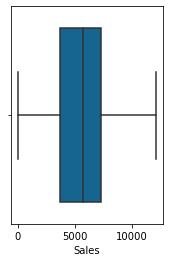

C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


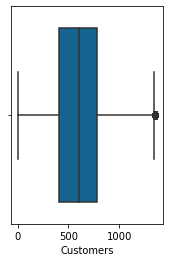

In [46]:
plotvar(train_data, 'Sales')
plotvar(train_data, 'Customers')

In [47]:
test_data.info()
train_data.info()
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41088 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Store          1017209 non-null  int64  
 1   DayOfWeek      1017209 non-null  int64  
 2   Date           1017209 non-null  object 
 3   Sales          1017209 non-null  float64
 4

C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


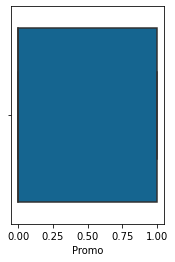

C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


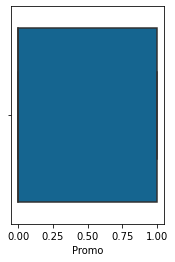

In [48]:
#Check distribution
plotvar(test_data,'Promo')
plotvar(train_data,'Promo')

# Plots

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

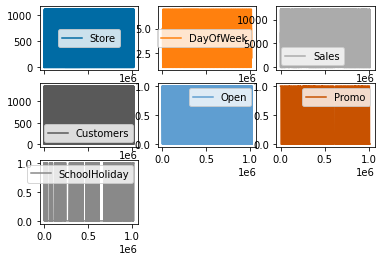

In [49]:
# line plot of dataset
train_data.plot(subplots=True, layout=(3,3))

In [50]:
train_data['DayOfWeek'].describe()

count    1.017209e+06
mean     3.998341e+00
std      1.997391e+00
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      6.000000e+00
max      7.000000e+00
Name: DayOfWeek, dtype: float64

In [51]:
train_data['Sales'].describe()

count    1.017209e+06
mean     5.301206e+03
std      3.110976e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.352000e+03
max      1.213700e+04
Name: Sales, dtype: float64

In [52]:
train_data['Customers'].describe()

count    1.017209e+06
mean     5.682254e+02
std      3.352674e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      7.800000e+02
max      1.362000e+03
Name: Customers, dtype: float64

In [53]:
#sb.relplot(data=train_data, x="Sales", y="DayOfWeek", hue="Customers",kind="line", height=4, aspect=.7)

<AxesSubplot:xlabel='DayOfWeek'>

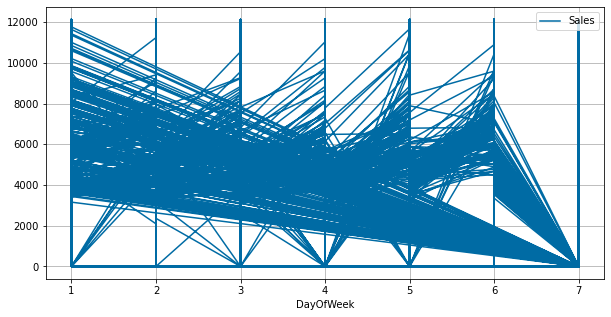

In [54]:
train_data.plot(x='DayOfWeek', y='Sales' ,figsize=(10,5), grid=True)

In [55]:
store_data.head(1)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [56]:
plt.figure(figsize=(6,6))
sb.set(style="whitegrid")
sb.boxenplot(data=train_data,scale="linear",x="Sales",y="DayOfWeek",color="Black")

<AxesSubplot:xlabel='Sales', ylabel='DayOfWeek'>

Error in callback <function flush_figures at 0x0000011FE8418C10> (for post_execute):


KeyboardInterrupt: 

KeyboardInterrupt: 

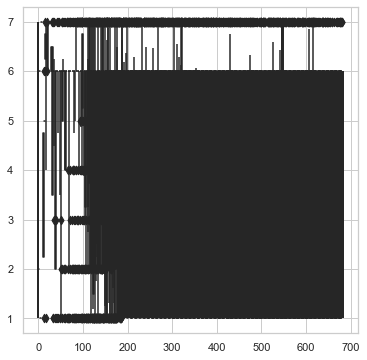

In [57]:
plt.figure(figsize=(6,6))
sb.set(style="whitegrid")
sb.boxenplot(data=train_data,scale="linear",x="Customers",y="DayOfWeek",color="green")

C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Customers', ylabel='Density'>

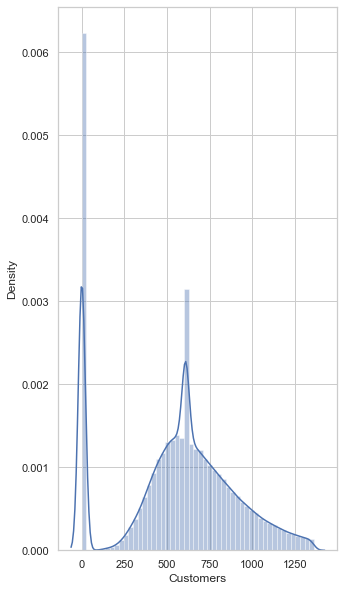

In [81]:
#Find the range of the data
plt.figure(figsize=(5,10))
sb.set(style="whitegrid")
sb.distplot(train_data["Customers"])

C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Sales', ylabel='Density'>

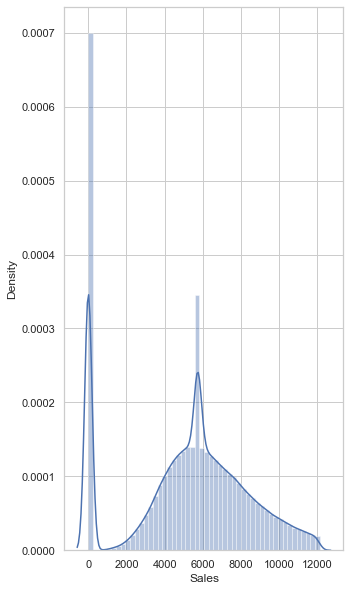

In [82]:
#Find the range of the data
plt.figure(figsize=(5,10))
sb.set(style="whitegrid")
sb.distplot(train_data["Sales"])

In [59]:
#Adding salespercustomer column
train_data['SalesperCustomer']=train_data['Sales']/train_data['Customers']
train_data['Salesperstore']=train_data['Sales']/train_data['Store']

In [60]:
train_data['Salesperstore'].describe()

count    1.017209e+06
mean     3.510512e+01
std      1.930791e+02
min      0.000000e+00
25%      5.132114e+00
50%      9.446101e+00
75%      1.908257e+01
max      9.528000e+03
Name: Salesperstore, dtype: float64

In [84]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

In [85]:
train_data['Year']=train_data.Date.dt.year

In [88]:
train_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'SalesperCustomer', 'Year'],
      dtype='object')

#correlation Analysis

In [89]:
df_correlation=train_data[['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'SalesperCustomer', 'Year']]

In [90]:
df_correlation.corr()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,SalesperCustomer,Year
Store,1.000000,-0.000008,-0.002453,0.017024,-0.000047,0.000058,0.000641,-0.040006,0.000290
DayOfWeek,-0.000008,1.000000,-0.483996,-0.478390,-0.528963,-0.392925,-0.205388,-0.026578,0.001937
Sales,-0.002453,-0.483996,1.000000,0.874982,0.770902,0.449832,0.086174,0.409320,0.026589
Customers,0.017024,-0.478390,0.874982,1.000000,0.766744,0.374705,0.084126,-0.335318,0.005540
Open,-0.000047,-0.528963,0.770902,0.766744,1.000000,0.295042,0.086171,NaN,-0.001009
Promo,0.000058,-0.392925,0.449832,0.374705,0.295042,1.000000,0.067483,0.186570,0.024300
SchoolHoliday,0.000641,-0.205388,0.086174,0.084126,0.086171,0.067483,1.000000,0.005747,-0.036535
SalesperCustomer,-0.040006,-0.026578,0.409320,-0.335318,NaN,0.186570,0.005747,1.000000,0.050350
Year,0.000290,0.001937,0.026589,0.005540,-0.001009,0.024300,-0.036535,0.050350,1.000000


<ipython-input-95-1ce79089e30e>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sb.heatmap(df_correlation.corr(), mask=np.zeros_like(df_correlation.corr(), dtype=np.bool), cmap=sb.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:>

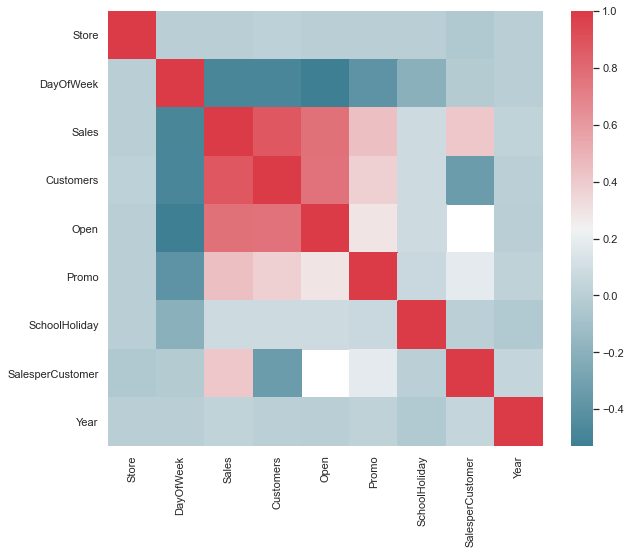

In [95]:
#plot corrilation
f, ax = plt.subplots(figsize=(10, 8))
sb.heatmap(df_correlation.corr(), mask=np.zeros_like(df_correlation.corr(), dtype=np.bool), cmap=sb.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

<AxesSubplot:xlabel='Sales'>

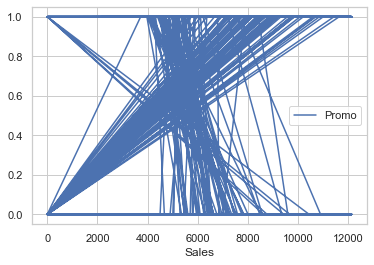

In [114]:
train_data.plot( 'Sales' , 'Promo')

<AxesSubplot:xlabel='Customers'>

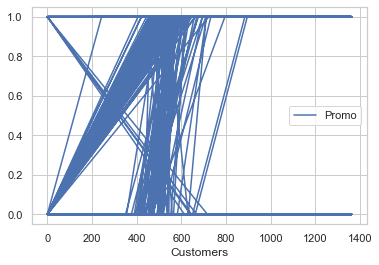

In [115]:
train_data.plot( 'Customers' , 'Promo')

In [67]:
# merge the train/test sets with the stores set
store_train = pd.merge(left = train_data, right = store_data, how = 'inner', left_on = 'Store', right_on = 'Store')
store_test = pd.merge(left = test_data, right = store_data, how = 'inner', left_on = 'Store', right_on = 'Store')
print(store_train.shape)
print(store_test.shape)


(1017209, 20)
(41088, 17)


In [65]:
store_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37115088 entries, 0 to 37115087
Data columns (total 18 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Store             int64  
 1   DayOfWeek_x       int64  
 2   Date_x            object 
 3   Sales             float64
 4   Customers         float64
 5   Open_x            int64  
 6   Promo_x           int64  
 7   StateHoliday_x    object 
 8   SchoolHoliday_x   int64  
 9   SalesperCustomer  float64
 10  Salesperstore     float64
 11  Id                int64  
 12  DayOfWeek_y       int64  
 13  Date_y            object 
 14  Open_y            float64
 15  Promo_y           int64  
 16  StateHoliday_y    object 
 17  SchoolHoliday_y   int64  
dtypes: float64(5), int64(9), object(4)
memory usage: 5.3+ GB


In [120]:
store_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41088 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        41088 non-null  float64
 11  CompetitionOpenSinceMonth  41088 non-null  float64
 12  CompetitionOpenSinceYear   41088 non-null  float64
 13  Promo2                     41088 non-null  int

<ipython-input-123-c1074eda5e16>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sb.heatmap(store_train.corr(), mask=np.zeros_like(store_train.corr(), dtype=np.bool), cmap=sb.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:>

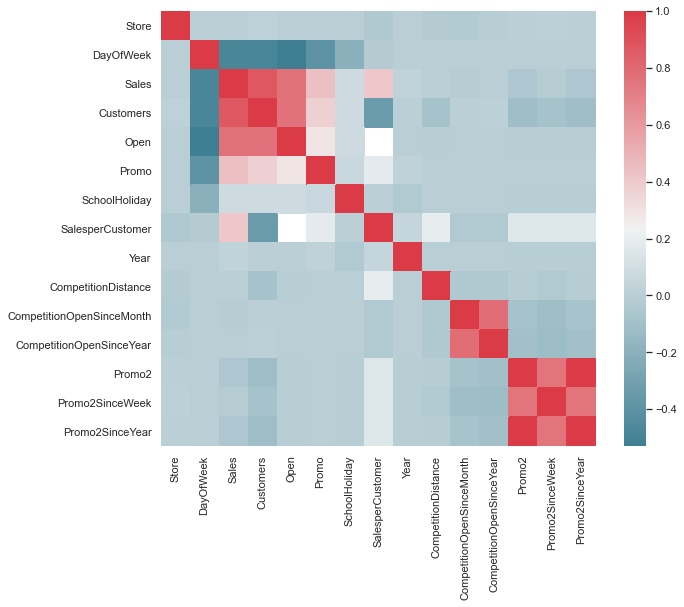

In [123]:
f, ax = plt.subplots(figsize=(10, 8))
sb.heatmap(store_train.corr(), mask=np.zeros_like(store_train.corr(), dtype=np.bool), cmap=sb.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [128]:
store_train.corr()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,SalesperCustomer,Year,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
Store,1.000000,-8.483588e-06,-0.002453,0.017024,-0.000047,0.000058,0.000641,-0.040006,0.000290,-2.444426e-02,-0.032893,-0.008794,0.008488,0.011053,0.008520
DayOfWeek,-0.000008,1.000000e+00,-0.483996,-0.478390,-0.528963,-0.392925,-0.205388,-0.026578,0.001937,-1.928666e-07,0.000008,0.000007,0.000168,0.000208,0.000168
Sales,-0.002453,-4.839965e-01,1.000000,0.874982,0.770902,0.449832,0.086174,0.409320,0.026589,1.674440e-03,-0.010413,-0.003161,-0.053008,-0.019726,-0.053023
Customers,0.017024,-4.783901e-01,0.874982,1.000000,0.766744,0.374705,0.084126,-0.335318,0.005540,-8.574590e-02,0.002925,0.010251,-0.111384,-0.081356,-0.111360
Open,-0.000047,-5.289625e-01,0.770902,0.766744,1.000000,0.295042,0.086171,NaN,-0.001009,-4.028457e-03,-0.000200,-0.001144,-0.008309,-0.007436,-0.008308
Promo,0.000058,-3.929253e-01,0.449832,0.374705,0.295042,1.000000,0.067483,0.186570,0.024300,-4.366473e-06,-0.000039,-0.000034,-0.000983,-0.001210,-0.000983
SchoolHoliday,0.000641,-2.053883e-01,0.086174,0.084126,0.086171,0.067483,1.000000,0.005747,-0.036535,-2.377178e-03,-0.001688,-0.001801,-0.006909,-0.006679,-0.006912
SalesperCustomer,-0.040006,-2.657768e-02,0.409320,-0.335318,NaN,0.186570,0.005747,1.000000,0.050350,1.973544e-01,-0.038191,-0.034145,0.154053,0.154705,0.153961
Year,0.000290,1.937284e-03,0.026589,0.005540,-0.001009,0.024300,-0.036535,0.050350,1.000000,-1.972322e-05,-0.000203,-0.000176,-0.004982,-0.006135,-0.004983
CompetitionDistance,-0.024444,-1.928666e-07,0.001674,-0.085746,-0.004028,-0.000004,-0.002377,0.197354,-0.000020,1.000000e+00,-0.042051,-0.044041,-0.010540,-0.033655,-0.010637


In [ ]:
df_testsummary1 = store_train.pivot_table(values='Sales', index='experiment', aggfunc=np.sum)

In [ ]:
"def preprocess_data(full_train, full_test):\n",
    "\n",
    "    # dependent and independent variables\n",
    "    global train_features, train_target, test_features\n",
    "    train_features = full_train.drop(['Sales'], axis = 1) #drop the target feature + customers (~ will not be used for prediction)\n",
    "    train_target  = full_train[['Sales']]\n",
    "    test_features = full_test.drop(['Id'], axis = 1) #drop id, it's required only during submission\n",
    "    test_features['Customers'] = 0\n",
    "    \n",
    "    #feature generation + transformations\n",
    "    def feature_generation(data):\n",
    "        data['Date'] = pd.to_datetime(data.Date)\n",
    "        data['Month'] = data.Date.dt.month.to_list()\n",
    "        data['Year'] = data.Date.dt.year.to_list()\n",
    "        data['Day'] = data.Date.dt.day.to_list()\n",
    "        data['WeekOfYear'] = data.Date.dt.weekofyear.to_list()\n",
    "        data['DayOfWeek'] = data.Date.dt.dayofweek.to_list()\n",
    "        data['weekday'] = 1        # Initialize the column with default value of 1\n",
    "        data.loc[data['DayOfWeek'] == 5, 'weekday'] = 0\n",
    "        data.loc[data['DayOfWeek'] == 6, 'weekday'] = 0\n",
    "#         data = data.drop(['Date'], axis = 1)\n",
    "        \n",
    "        return data\n",

In [129]:
store_test.corr()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
Id,1.000000,2.083250e-02,5.483047e-02,-0.048435,-1.690971e-02,0.387661,-1.591836e-03,2.661167e-04,2.496024e-04,6.020791e-04,5.397860e-04,6.031289e-04
Store,0.020833,1.000000e+00,-1.188917e-15,0.000684,1.910305e-15,-0.011757,-7.668783e-02,1.242172e-02,1.159378e-02,2.957459e-02,2.649710e-02,2.962493e-02
DayOfWeek,0.054830,-1.188917e-15,1.000000e+00,-0.610053,-4.355177e-01,-0.352948,2.141825e-16,-3.025390e-17,-1.010726e-16,-4.292938e-17,-6.072674e-17,-4.280249e-17
Open,-0.048435,6.838394e-04,-6.100535e-01,1.000000,3.322952e-01,0.278623,-1.712802e-03,3.155600e-04,-9.937876e-04,-1.191186e-02,-1.427419e-02,-1.190988e-02
Promo,-0.016910,1.910305e-15,-4.355177e-01,0.332295,1.000000e+00,0.219202,-9.282269e-17,6.157772e-17,6.248440e-17,-5.520214e-18,-4.068437e-18,-7.403353e-18
SchoolHoliday,0.387661,-1.175748e-02,-3.529484e-01,0.278623,2.192020e-01,1.000000,5.048191e-02,1.295232e-02,3.496277e-03,6.772487e-02,5.880575e-02,6.771015e-02
CompetitionDistance,-0.001592,-7.668783e-02,2.141825e-16,-0.001713,-9.282269e-17,0.050482,1.000000e+00,1.107135e-02,-5.462119e-03,-9.268989e-02,-1.038260e-01,-9.275588e-02
CompetitionOpenSinceMonth,0.000266,1.242172e-02,-3.025390e-17,0.000316,6.157772e-17,0.012952,1.107135e-02,1.000000e+00,8.059437e-01,-4.304925e-03,-3.267646e-02,-4.218673e-03
CompetitionOpenSinceYear,0.000250,1.159378e-02,-1.010726e-16,-0.000994,6.248440e-17,0.003496,-5.462119e-03,8.059437e-01,1.000000e+00,-1.966799e-02,-5.269177e-02,-1.958195e-02
Promo2,0.000602,2.957459e-02,-4.292938e-17,-0.011912,-5.520214e-18,0.067725,-9.268989e-02,-4.304925e-03,-1.966799e-02,1.000000e+00,7.450685e-01,9.999992e-01


In [61]:
store_train = pd.merge(left = train_data, right = test_data, how = 'inner', left_on = 'Store', right_on = 'Store')

In [84]:
df_testsummary1 =store_train.pivot_table(values='Sales', index='Open', aggfunc=np.sum)
df_testsummary =store_train.pivot_table(values='Sales', index='SchoolHoliday', aggfunc=np.sum)
df_testsummary2 =store_train.pivot_table(values='Sales', index='StateHoliday', aggfunc=np.sum)


In [81]:
df_testsummary1

,Sales
Open,
0,0.000000e+00
1,5.392434e+09


In [82]:
df_testsummary

,Sales
SchoolHoliday,
0,4.324635e+09
1,1.067799e+09


In [85]:
df_testsummary2

,Sales
StateHoliday,
0,7.015899e+08
0,4.685195e+09
a,4.317522e+06
b,8.598890e+05
c,4.718860e+05


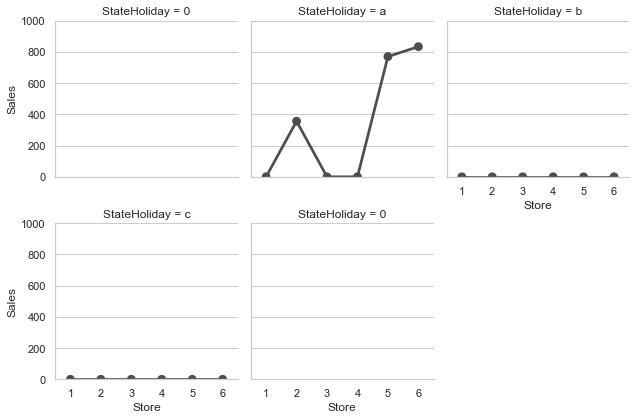

In [89]:
g = sb.FacetGrid(store_train, col="StateHoliday", col_wrap=3, height=3, ylim=(0, 1000))
g.map(sb.pointplot, "Store", "Sales", color=".3", ci=None, order = [1,2,3,4,5,6]);

In [90]:
df_testsummary3 =store_train.pivot_table(values='Customers', index='Open', aggfunc=np.sum)


In [91]:
df_testsummary3

,Customers
Open,
0,0.0
1,578004009.0


In [116]:
store_train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'SalesperCustomer', 'Salesperstore',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'weekly_sales',
       'day_sales'],
      dtype='object')

In [117]:
store_test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [125]:
store_test['date'] = pd.to_datetime(store_test['Date'])
store_train['day_sales'] = store_train['Sales'] * store_train['DayOfWeek']
#store_train.set_index('Date', inplace=True)
#store_train['year'] = store_train.index.year
#store_train['month'] = dstore_train.index.month
#store_train['day'] = store_train.index.day
#store_train['week_of_year'] = store_train.index.weekofyear
#store_train['Date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))

In [129]:
store_test['Date'] = pd.to_datetime(store_test['Date'])
x=store_test['Date'].dt.week

<ipython-input-129-9b2f7c6638f2>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  x=store_test['Date'].dt.week


In [134]:
df_testsummary4 =store_train.pivot_table(values='Open', index='DayOfWeek')

In [154]:
day=store_train['DayOfWeek'].unique()
store_train['sales_day']=store_train.groupby(store_train['DayOfWeek'])
#plt.xticks(day,rotation='vertical')

ValueError: Length of values (7) does not match length of index (1017209)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


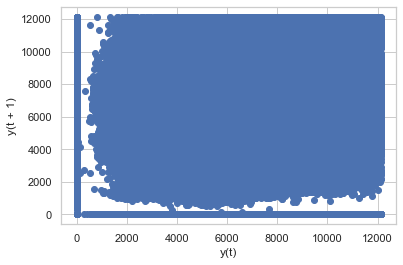

In [162]:
# lag plot of time series
from pandas.plotting import lag_plot
lag_plot(train_data['Sales'])
plt.show()

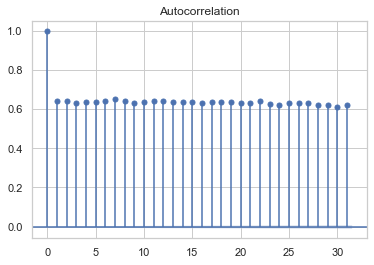

In [165]:

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['Sales'], lags=31)
plt.show()